# beeHealth Tutorial
### An introduction to synthetic data generation and metric development.
##### Michał Kozłowski, Miquel Perelló Nieto, Ryan McConville

The purpose of this tutorial is to introduce the synthetic data generation and metric plotting. This is for users to evaluate their own metrics and quality of data.

If you haven't yet checked the tutorial for real-life data, do that before starting this example. This is because some code will not be explained in this tutorial.

# Synthetic Example of Accelerometer-based activity recognition

In this section we will cover the use of 3-dimensional accelerometer signal as a basis for preprocessing, stratification, validation, classification and subsequent activity recognition metrics extraction for synthetic data. 

### Dependencies:

In [7]:
import sys
sys.path.append('../')

import os
import pandas as pd
import numpy as np
from scipy import stats

from glob import glob

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.ma as ma

from datetime import datetime, timedelta

from digihealth.visualisations import plot_metrics
from digihealth.visualisations import features_figure

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

from digihealth.synthetic import RandomTimeSeries
#from synthetic import RandomTimeSeries
from digihealth.metric_wrappers import Wrapper

import warnings
warnings.filterwarnings('ignore')

### Note, that here we generate our own data from pre-assigned functions and models. In this particular example, we assume that a number of different labels can be modelled as a function of oscillation - others can be entirely random. 

We specify the generators through the use of lambdas as seen in lines 9:21.

We then provide numerical labels for each of the generators. (line 23)

The time series is generated (line 24-27) using specified dates. You can select any dates you wish - this is to simulate longitudinal studies.

In [8]:
def get_raw_ts_X_y():
    def sin_gaussian_rand(n_samples, size):
        return np.sin(np.repeat(np.arange(n_samples), size).reshape(n_samples, size)
                        ) + np.random.randn(n_samples, size)

    n_features = 7
    features = ['Acceleration X', 'Acceleration Y', 'Acceleration Z']
    # First example
    generator_list = [lambda: np.random.randn(np.random.randint(1, 100), 3)/2
                                + [0, -1, 0],
                      lambda: np.random.randn(np.random.randint(10, 300), 3)/2
                                + [0, 0, -1],
                      lambda: sin_gaussian_rand(np.random.randint(15, 300), 3)
                                + [0, -1, 0],
                      lambda: sin_gaussian_rand(np.random.randint(30, 90), 3)*2
                                + [0, 0, -1],
                      lambda: np.random.randn(np.random.randint(5*60, 10*60), 3)/16
                                + [-0.5, 0.5, 0],
                      lambda: np.random.randn(np.random.randint(5 * 60, 10 * 60), 3) / 16
                              + [-0.5, 0.5, 0]
                     ]

    labels = [0, 1, 2, 3, 4, 5]
    rts = RandomTimeSeries(generator_list, labels=labels,
                           priors=[3, 4, 2, 1, 1, 1], samplesize='1Min')

    ts, X, y = rts.generate('06/02/2019', '13/02/2019')

    ts = ts.values

    return ts, X, y, labels, features

In [9]:
def preprocess_X_y(ts, X, y):
    return ts, X, y

In [10]:
def split_train_test(ts, X, y):
    # Create train and test partitions
    skf = StratifiedKFold(n_splits=2, shuffle=False)
    y = y.astype(int)
    train_index, test_index = skf.split(X, y).__next__()
    train = ts[train_index], X[train_index], y[train_index]
    test = ts[test_index], X[test_index], y[test_index]
    return train, test

In [11]:
def get_classifier_grid():
    # Create cross-validation partitions from training
    # This should select the best set of parameters
    cv = StratifiedKFold(n_splits=3, shuffle=False)

    models = {'rf': {'model': RandomForestClassifier(),
                     'parameters': {'n_estimators': [200],
                                    'min_samples_leaf': [1]}}
              }

    classifier_name = 'rf'

    steps = [('imputer', SimpleImputer(missing_values=np.nan,
                                       strategy='mean')),
             ('scaler', StandardScaler()),
             ('clf', models[classifier_name]['model'])]

    pipeline = Pipeline(steps)

    pipeline_parameters = {'clf__' + key: value for key, value in
                           models[classifier_name]['parameters'].items()}

    clf_grid = GridSearchCV(pipeline, param_grid=pipeline_parameters, cv=cv,
                            refit=True)
    return clf_grid


In [12]:
def print_summary(clf_grid, X_test, y_test):
    print('Best parameters are: {}'.format(clf_grid.best_params_))
    print("CV accuracy "+str(np.mean(clf_grid.cv_results_['mean_test_score'])))

    # The best model was fitted on the full training data, here tested only
    tt_score = clf_grid.score(X_test, y_test)
    print("Train / test split accuracy "+str(tt_score))

### Note the difference between activity metrics in synthetic example and the non-synthetic example. The descriptor map is required for each parameter set of the environment or user. In the synthetic example we assumed that the categorical labels follow different numerical labels.

In [13]:
def activity_metrics(labels, timestamps, span):
    """Outputs typical activity metrics."""

    descriptor_map = {
        'eating': 0,
        'sitting': 1,
        'walking': 2,
        'studying': 3,
        'sleeping': 4,
        'washing': 5
    }

    metrics = Wrapper(labels, timestamps, span, 1, 25, descriptor_map, adjecency=None)

    df_time = timestamps.astype('datetime64')
    df_time = pd.DataFrame(df_time, columns=['Time'])
    df_label = pd.DataFrame(labels, columns=['Label'])

    metric_array = [metrics.duration_sitting,
                    metrics.duration_walking,
                    metrics.duration_washing,
                    metrics.duration_eating,
                    metrics.duration_sleeping,
                    metrics.duration_studying,
                    metrics.number_of_unique_activities]

    metric_container, date_container = metrics.run_metric_array(metric_array)

    return metric_container, date_container

### The main function remains largely identical, with the exception of the features_figure plot, which we add right after generating the dataset. Due to the size of the set, we can downsample by a factor of 50 in order to broadly show the generated dataset.

Best parameters are: {'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}
CV accuracy 0.6597180861623982


No handles with labels found to put in legend.


Train / test split accuracy 0.670037675986516


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


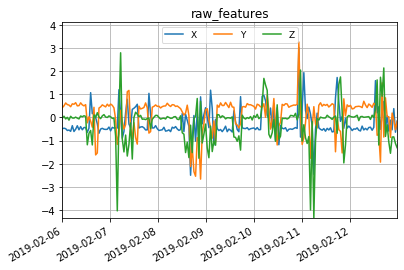

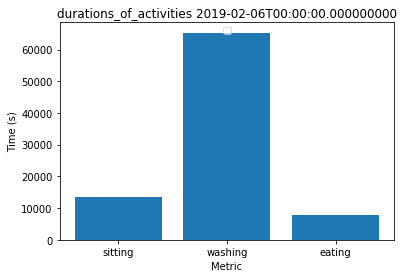

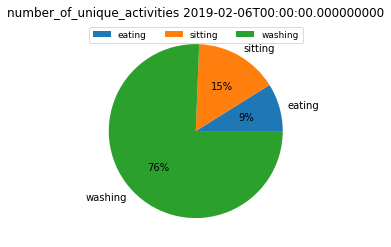

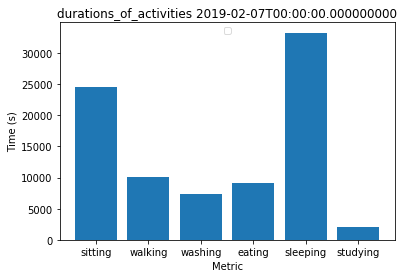

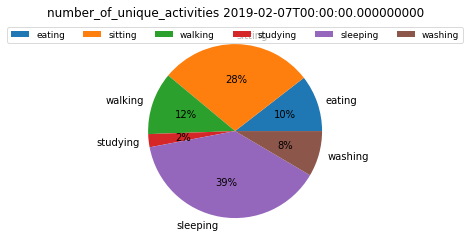

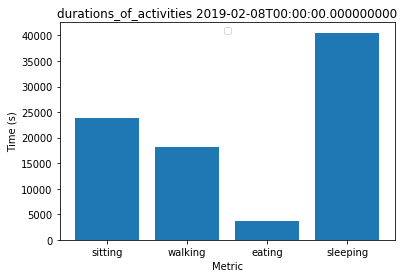

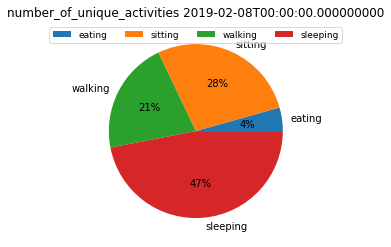

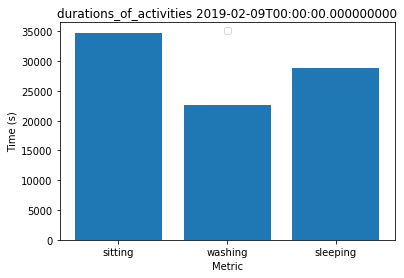

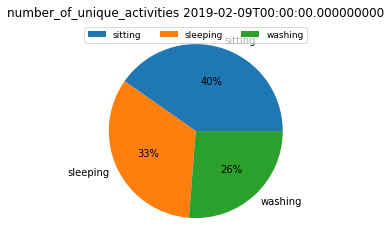

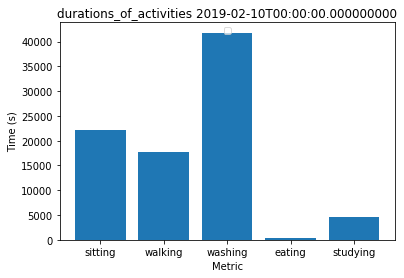

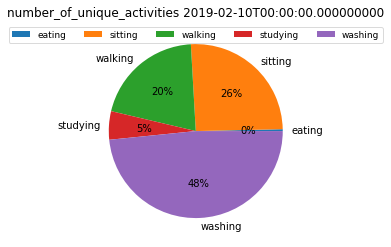

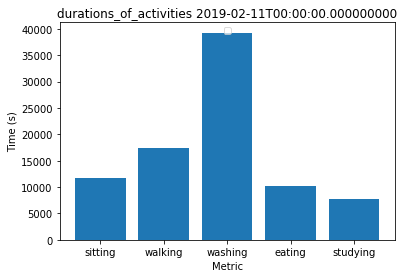

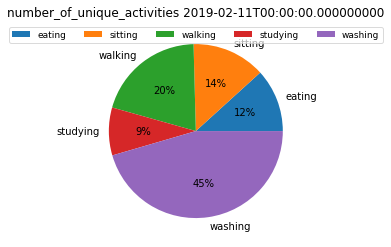

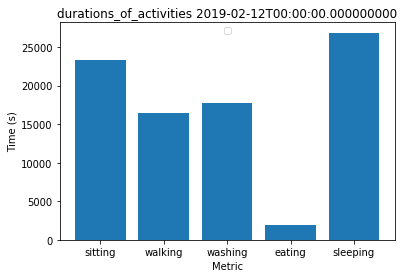

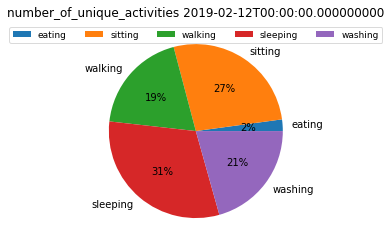

In [14]:
if __name__ == '__main__':
    ts, X, y, labels, features = get_raw_ts_X_y()

    features_figure(X[0:X.size:50], ts[0:ts.size:50], feature_names=['X', 'Y', 'Z'])

    ts, X, y = preprocess_X_y(ts, X, y)
    (ts_train, X_train, y_train), (ts_test, X_test, y_test) = split_train_test(ts, X, y)
    clf_grid = get_classifier_grid()
    clf_grid.fit(X_train, y_train)
    print_summary(clf_grid, X_test, y_test)

    metric_container_daily, date_container_daily = activity_metrics(y, ts, 'daily')
    plot_metrics(metric_container_daily, date_container_daily)



# Synthetic Example of RSSI-based indoor localisation

We continue with our example synthetic data. Again, dependencies:

In [32]:
import sys
sys.path.append('../')

import os
import pandas as pd
import numpy as np
from scipy import stats

from glob import glob

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.ma as ma

from datetime import datetime, timedelta
from digihealth.visualisations import plot_metrics
from digihealth.visualisations import features_figure
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

from digihealth.synthetic import RandomTimeSeries
from digihealth.metric_wrappers import Wrapper


np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

### We generate a single day of data, much the same way as we did with the accelerometer. Note here that the feature set is larger, and correspondingly will take longer to process.

The 'rssi_' label names correspond to various rooms where these sensors can be placed. In this example, the RSS does not follow any model of shadowing or diffraction. In reality, the implementation of these models would be crucial in modelling these sort of systems. In our example, we only care about the processing and subsequent metric analysis, so this is good enough.

Again, using lambdas, we create the list of function generators (lines 9-20)

We can select the time span of the generation in line 26.

In [33]:
def get_raw_ts_X_y():
    def sin_gaussian_rand(n_samples, size):
        return np.sin(np.repeat(np.arange(n_samples), size).reshape(n_samples, size)
                        ) + np.random.randn(n_samples, size)

    n_features = 7
    features = ['rssi bathroom', 'rssi bedroom 1', 'rssi stairs', 'rssi hall',
                'rssi kitchen', 'rssi living room']
    generator_list = [
        lambda: np.random.randn(np.random.randint(2, 6), n_features)
                + [3, 1, 0, 1, 0, 0, 0],
        lambda: sin_gaussian_rand(np.random.randint(5*6, 8*6), n_features)
                + [0, 4, 1, 2, 1, 1, 0],
        lambda: np.random.randn(np.random.randint(3, 9), n_features)
                + [0, 1, 0, 5, 0, 0, 1],
        lambda: sin_gaussian_rand(np.random.randint(1, 9), n_features)
                + [1, 1, 0, 1, 2, 4, 3],
        lambda: np.random.randn(np.random.randint(3, 12), n_features)
                + [0, 1, 1, 0, 2, 3, 9],
                ]

    labels = [0, 1, 2, 3, 4]
    rts = RandomTimeSeries(generator_list, labels=labels,
                           priors=[5, 2, 4, 3, 1], samplesize='1Min')

    ts, X, y = rts.generate('01-01-2019', '08-01-2019')

    ts = ts.values

    return ts, X, y, labels, features

In [34]:
def preprocess_X_y(ts, X, y):
    return ts, X, y

In [35]:
def split_train_test(ts, X, y):
    # Create train and test partitions
    skf = StratifiedKFold(n_splits=2, shuffle=False)
    y = y.astype(int)
    train_index, test_index = skf.split(X, y).__next__()
    train = ts[train_index], X[train_index], y[train_index]
    test = ts[test_index], X[test_index], y[test_index]
    return train, test

In [40]:
def get_classifier_grid():
    # Create cross-validation partitions from training
    # This should select the best set of parameters
    cv = StratifiedKFold(n_splits=3, shuffle=False)

    models = {'rf': {'model': RandomForestClassifier(),
                     'parameters': {'n_estimators': [200],
                                    'min_samples_leaf': [1]}}
              }

    classifier_name = 'rf'

    steps = [('imputer', SimpleImputer(missing_values=np.nan,
                                       strategy='mean')),
             ('scaler', StandardScaler()),
             ('clf', models[classifier_name]['model'])]

    pipeline = Pipeline(steps)

    pipeline_parameters = {'clf__' + key: value for key, value in
                           models[classifier_name]['parameters'].items()}

    clf_grid = GridSearchCV(pipeline, param_grid=pipeline_parameters, cv=cv,
                            refit=True)
    return clf_grid

In [41]:
def print_summary(clf_grid, X_test, y_test):
    print('Best parameters are: {}'.format(clf_grid.best_params_))
    print("CV accuracy "+str(np.mean(clf_grid.cv_results_['mean_test_score'])))

    # The best model was fitted on the full training data, here tested only
    tt_score = clf_grid.score(X_test, y_test)
    print("Train / test split accuracy "+str(tt_score))

### The locations and their adjecency needs to be 'hardwired' into the example. The provision of the adjecency matrix (as well as distances between states) is necessary for the calculation of the velocity in the later metrics.



In [44]:
def localisation_metrics(labels, timestamps, span):
    """Outputs typical activity metrics."""

    descriptor_map = {
        'bathroom' : [0],
        'bedroom 1' : [1],
        'bedroom 2' : [2],
        'kitchen' : [3],
        'living room' : [4]
    }

    adjecency = [[0, 2.5, 3, 3.3, 4],
                 [2.5, 0, 6, 1.5, 2],
                 [3, 6, 0, 4, 1],
                 [3.3, 1.5, 4, 0, 1],
                 [4, 3, 1, 1, 0]]

    metrics = Wrapper(labels, timestamps, span, 1, 25, descriptor_map, adjecency)

    df_time = timestamps.astype('datetime64')
    df_time = pd.DataFrame(df_time, columns=['Time'])
    df_label = pd.DataFrame(labels, columns=['Label'])

    metric_array= [ metrics.walking_speed,
                    metrics.room_transfers,
                    metrics.number_of_unique_locations]

    metric_container, date_container = metrics.run_metric_array(metric_array)

    return metric_container, date_container

Best parameters are: {'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}
CV accuracy 0.9831315737249454
Train / test split accuracy 0.9859154929577465


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


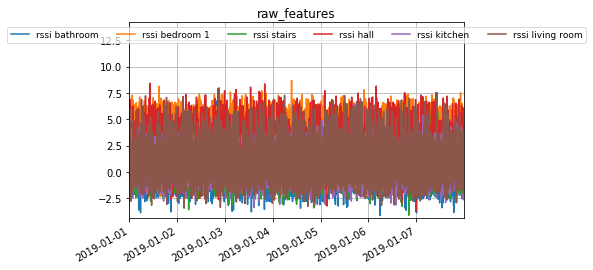

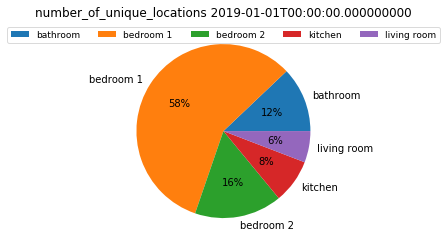

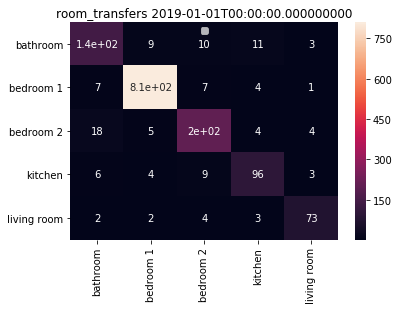

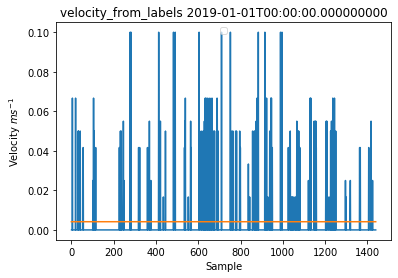

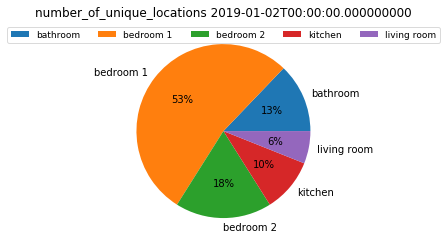

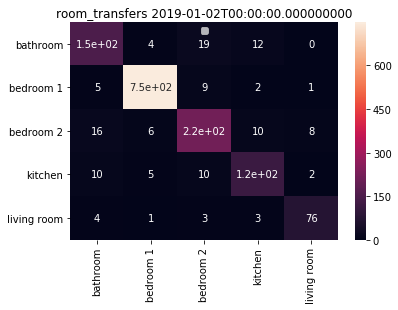

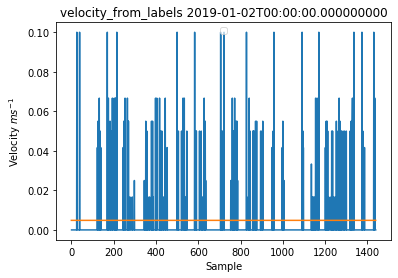

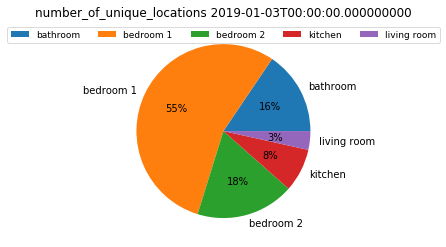

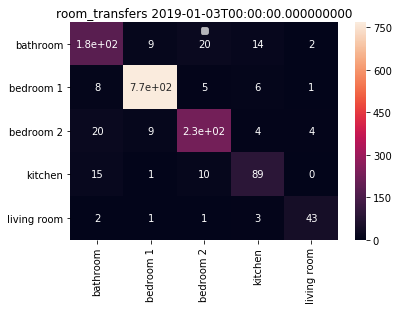

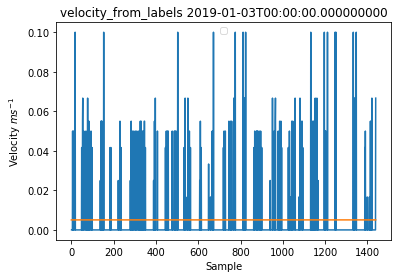

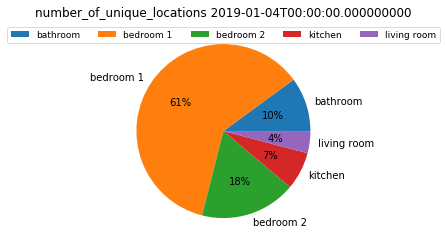

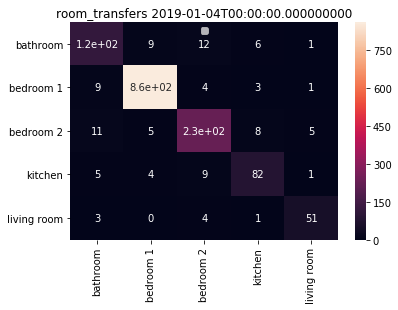

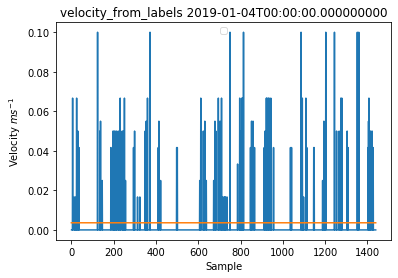

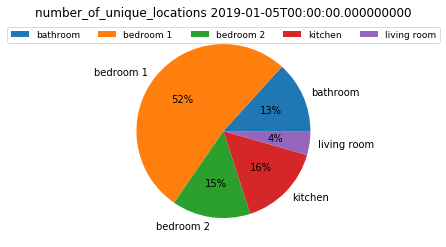

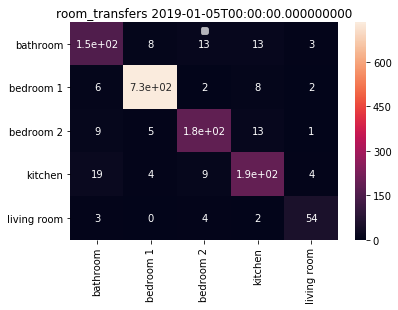

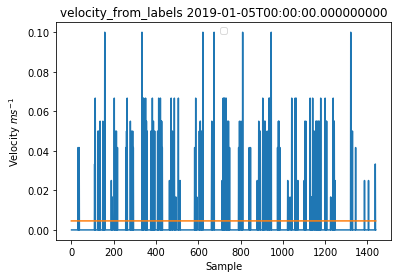

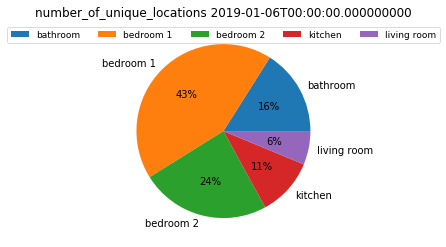

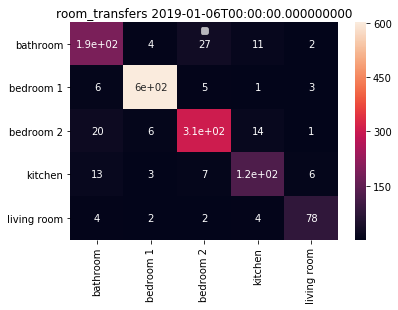

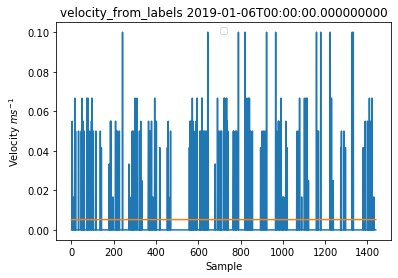

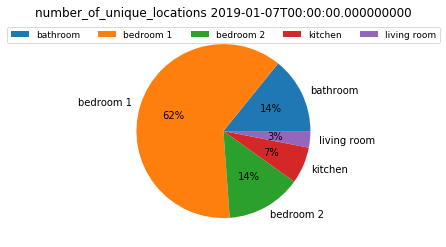

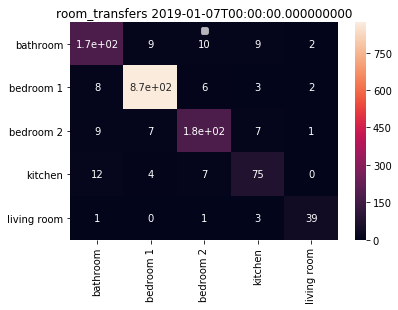

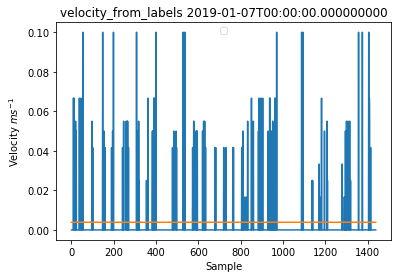

In [45]:
if __name__ == '__main__':
    ts, X, y, labels, features = get_raw_ts_X_y()

    features_figure(X, ts, feature_names=['rssi bathroom', 'rssi bedroom 1', 'rssi stairs', 'rssi hall',
                'rssi kitchen', 'rssi living room'])

    ts, X, y = preprocess_X_y(ts, X, y)
    (ts_train, X_train, y_train), (ts_test, X_test, y_test) = split_train_test(ts, X, y)
    clf_grid = get_classifier_grid()
    clf_grid.fit(X_train, y_train)
    print_summary(clf_grid, X_test, y_test)

    metric_container_daily, date_container_daily = localisation_metrics(y, ts, 'daily')
    plot_metrics(metric_container_daily, date_container_daily, labels_=['bathroom',
                                                                        'bedroom 1',
                                                                        'bedroom 2',
                                                                        'kitchen',
                                                                        'living room'])

    plt.show()